In [1]:
!pip install wordcloud
!pip install tensorflow


In [2]:

# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv(r"C:\Users\ayush\Desktop\spam detection\Dataset\spam.csv")

# Rename the column 'Category' to 'Spam'
data = data.rename(columns={'Category': 'spam' , 'Message': 'message'})

data.head()

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.shape

(5572, 2)

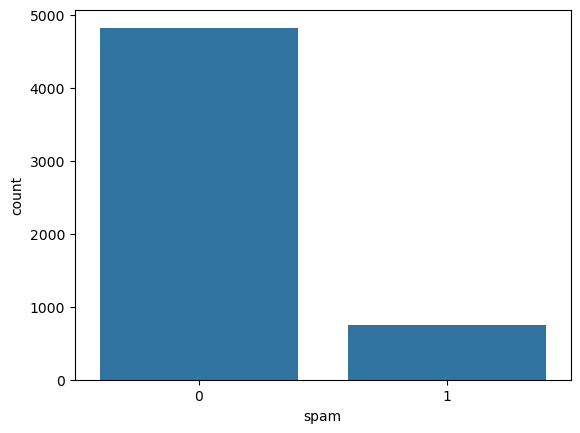

In [5]:
sns.countplot(x='spam', data=data)
plt.show()


In [6]:
# downsampling to balance the dataset 

ham_msg = data[data.spam == 0 ]
spam_msg = data[data.spam == 1]

ham_msg = ham_msg.sample(n = len(spam_msg),random_state = 42 )

Text(0.5, 0, 'Message types')

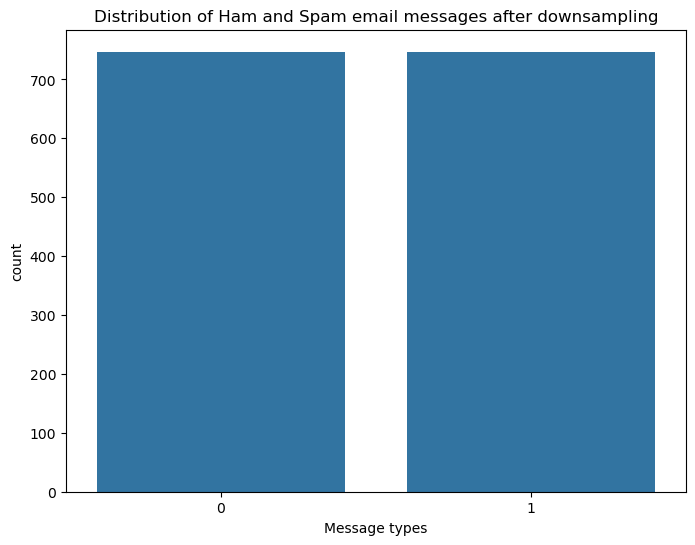

In [7]:
# Plotting the counts of down sampled dataset
balance_data = pd.concat([ham_msg,spam_msg]).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot( data = balance_data , x = 'spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')


In [8]:
balance_data['message'] = balance_data['message'].str.replace('Subject','')
balance_data.head()

,spam,message
0,0,If i not meeting ü all rite then i'll go home ...
1,0,"I.ll always be there, even if its just in spir..."
2,0,"Sorry that took so long, omw now"
3,0,I thk 50 shd be ok he said plus minus 10.. Did...
4,0,Dunno i juz askin cos i got a card got 20% off...


In [9]:
punctuations_list = string.punctuation

def remove_punctuations(message):
    temp = str.maketrans('','',punctuations_list)
    return message.translate(temp)

balance_data['message'] = balance_data['message'].apply(lambda x: remove_punctuations(x) )
balance_data.head()

,spam,message
0,0,If i not meeting ü all rite then ill go home l...
1,0,Ill always be there even if its just in spirit...
2,0,Sorry that took so long omw now
3,0,I thk 50 shd be ok he said plus minus 10 Did ü...
4,0,Dunno i juz askin cos i got a card got 20 off ...


In [10]:
def remove_stopwords(message):
    stop_wards = stopwords.words('english')
    imp_words = [] 

    for word in str(message).split():
        word = word.lower()

        if word not in stop_wards:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output 


balance_data['message'] = balance_data['message'].apply(lambda message : remove_stopwords(message) )
balance_data.head()

,spam,message
0,0,meeting ü rite ill go home lor ü dun feel like...
1,0,ill always even spirit ill get bb soon trying ...
2,0,sorry took long omw
3,0,thk 50 shd ok said plus minus 10 ü leave line ...
4,0,dunno juz askin cos got card got 20 4 salon ca...


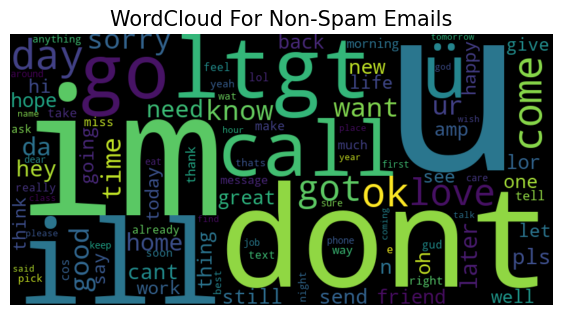

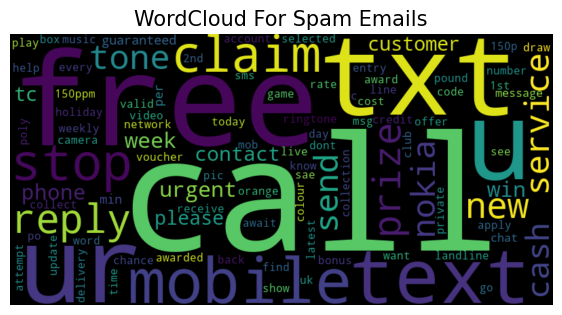

In [11]:
def plot_word_cloud(data,type):
    email_corpus = " ".join(data['message'])

    plt.figure(figsize=(7,7))

    wc = WordCloud(
        background_color='black',
        max_words=100 , 
        width = 800 , 
        height = 400 , 
        collocations = False).generate(email_corpus)

    plt.imshow(wc , interpolation='bilinear')
    plt.title(f'WordCloud For {type} Emails', fontsize=15)
    plt.axis('off')
    plt.show()


plot_word_cloud( balance_data[balance_data['spam'] == 0 ] , type = 'Non-Spam')
plot_word_cloud( balance_data[balance_data['spam'] == 1 ] , type = 'Spam')


In [12]:
# train test split 

train_X , test_X , train_Y , test_Y = train_test_split( 
                                                        balance_data['message'],
                                                        balance_data['spam'],
                                                        test_size=0.2,
                                                        random_state=42 )

In [13]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post',	truncating='post')


In [14]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# Save the tokenizer after fitting on the training data
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
print(len(tokenizer.word_index))  # Should be the number of unique tokens


4130


In [16]:
# Build the model
model = tf.keras.models.Sequential()

# Embedding layer with pre-trained embeddings (can switch to GloVe or Word2Vec if available)
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=100,  # Using a larger embedding dimension
                                    input_length=max_len))

# Bidirectional LSTM layer to capture context better
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))

# GlobalMaxPooling1D layer to pool information from the sequence
model.add(tf.keras.layers.GlobalMaxPooling1D())

# Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dropout(0.5))

# Fully connected layer
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Final output layer which outputs probabilities for the two classes.
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Smaller learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.build((None, max_len))

# Print the model summary to check the architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       413,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,901 (1.93 MB)

 Trainable params: 505,901 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# optimizer – This is the method that helps to optimize the cost function by using gradient descent.
# loss – The loss function by which we monitor whether the model is improving with training or not.
# metrics – This helps to evaluate the model by predicting the training and the validation data.

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'], optimizer = 'adam')


In [18]:
# Callbacks are used to check whether the model is improving with each epoch or not. 
# If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases the learning rate further? 
# Even then if model performance is not improving then training will be stopped by EarlyStopping. 

es = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

lr = ReduceLROnPlateau(patience=3, monitor='val_loss', factor=0.5, verbose=1)




In [19]:
# Train the model

history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=60,  # Increase epochs if necessary
                    batch_size=32,
                    callbacks=[es, lr])

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.6126 - loss: 0.6742 - val_accuracy: 0.8662 - val_loss: 0.3307 - learning_rate: 0.0010
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9438 - loss: 0.2018 - val_accuracy: 0.9197 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9776 - loss: 0.0780 - val_accuracy: 0.9365 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9953 - loss: 0.0240 - val_accuracy: 0.9331 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9962 - loss: 0.0161 - val_accuracy: 0.9431 - val_loss: 0.3096 - learning_rate: 0.0010
Epoch 6/60
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9992 - loss: 0.0090
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9991 - loss: 0.0098 - val_accu

In [20]:
# Save the model
model.save('spam_detection_model.keras')

In [21]:
# Evaluation the model 

test_loss , test_accuracy = model.evaluate( test_sequences , test_Y)

print('Test Loss: ' , test_loss )
print('Test Accuracy: ',test_accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9602 - loss: 0.2236
Test Loss:  0.30962300300598145
Test Accuracy:  0.9431437849998474


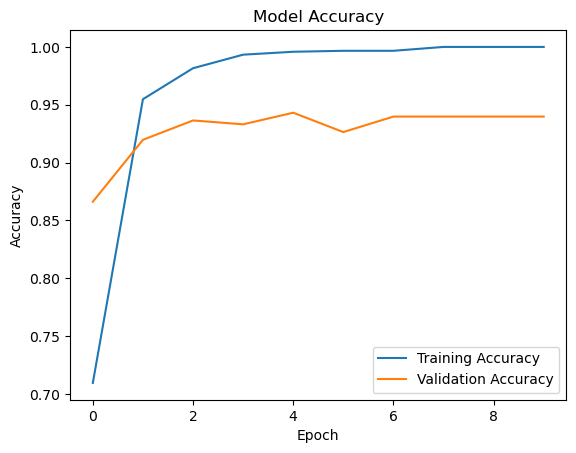

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [23]:
# Example input (new message)
new_messages = ["Congratulations, you won a free prize! Claim now.", "Hey, do you want to grab lunch?"]

# Convert the new messages to sequences and pad them
new_sequences = tokenizer.texts_to_sequences(new_messages)
new_sequences = pad_sequences(new_sequences, maxlen=max_len, padding='post', truncating='post')

# Predict using the trained model
predictions = model.predict(new_sequences)

# Convert probabilities to binary labels (0 for non-spam, 1 for spam)
predicted_labels = (predictions > 0.5).astype(int)

# Print the predictions
for msg, label in zip(new_messages, predicted_labels):
    print(f"Message: {msg} \nPredicted label: {'Spam' if label == 1 else 'Not Spam'}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
Message: Congratulations, you won a free prize! Claim now. 
Predicted label: Spam

Message: Hey, do you want to grab lunch? 
Predicted label: Not Spam



In [90]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Email sending function
def send_email(subject, body, to_email):
    # Set up the SMTP server (using Gmail here)
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587
    sender_email = 'ayusharyan473@gmail.com'  # Your email address
    sender_password = 'cwfx hwpv xorb hqwo'  # Your app-specific password for Gmail
    
    # Create message container
    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = to_email
    msg['Subject'] = subject
    
    # Attach the body of the email
    msg.attach(MIMEText(body, 'plain'))
    
    # Set up the server and send the email
    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()  # Secure the connection
        server.login(sender_email, sender_password)  # Log in to the server
        server.sendmail(sender_email, to_email, msg.as_string())  # Send email
        print("Email sent successfully!")
    except Exception as e:
        print(f"Error: {e}")
    finally:
        server.quit()  # Close the connection

# Integrate the model prediction and email notification
def model_prediction(input_data):
    # Preprocess the input (make sure it's tokenized and padded correctly)
    new_sequences = tokenizer.texts_to_sequences([input_data])
    new_sequences = pad_sequences(new_sequences, maxlen=max_len, padding='post', truncating='post')

    # Predict using the trained model
    prediction = model.predict(new_sequences)

    # Convert probabilities to binary labels (0 for non-spam, 1 for spam)
    predicted_label = (prediction > 0.5).astype(int)

    # If the model detects spam, send an email notification
    if predicted_label == 1:
        subject = "Spam Detection Alert"
        body = f"Spam message detected: {input_data}\n\nSpam Probability: {prediction[0][0]:.2f} (Spam) "
        send_email(subject, body, 'animeaddiction855@gmail.com')  # Replace with your recipient's email
        print(f"Message '{input_data}' classified as Spam. Email sent.")
    else:
        subject = "Spam Detection Alert"
        body = f"Message: {input_data}\n\nSpam Probability: {prediction[0][0]:.2f} (Not-Spam)"
        send_email(subject, body, 'animeaddiction855@gmail.com')  # Replace with your recipient's email
        print(f"Message '{input_data}' classified as Not-Spam. Email sent.")

# Example usage with a new message
input_data = "Congratulations! You've won a free iPhone. Click here to claim your prize!"  # Example spam message
model_prediction(input_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Email sent successfully!
Message 'Congratulations! You've won a free iPhone. Click here to claim your prize!' classified as Spam. Email sent.
